In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
#import tables
import itertools
import matplotlib
import glob
import math
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool
#from matplotlib_venn import venn2, venn2_circles
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Some example regions to plot

In [3]:
#region = 'chr6-135306757-135307157'#myb enhancer 1
#region = 'chr6-135321297-135321697'#myb enhancer 2
region = 'chr6-135323137-135323537' #myb enhancer 3
#region = 'chr6-135325637-135326037'#myb enhancer 4
#region = 'chr11-33881869-33882269'
#region = 'chr7-150960307-150960707'
#region = 'chr11-33941648-33942048'
#region = 'chr11-33944788-33945188'
#region = 'chr11-65422144-65422544'
#region = 'chr17-42319937-42320337'
#region = 'chr11-5280670-5280820'
#region = 'chr11-61834748-61834898'
#region = 'chr5-54313325-54313725' #linc promoter
#region = 'chr5-54325645-54326045' #arl15 enhancer
#region = 'chr18-2894277-2894677'
#region = 'chr18-322535-322935'
#region = 'chrX-66015153-66015553'
#region = 'chr20-47607171-47607571'
#region = 'chr6-135321297-135321697'
#region = 'chr6-135306757-135307157'
#region = 'chr10-17425896-17426296'
#region = 'chr6-146876419-146876819'
#region = 'chr18-48850844-48851244'
#region = 'chr1-12005538-12005938'
#region = 'chr11-33881869-33882269' #LMO2-enh-1
#region = 'chr11-33941648-33942048' #LMO2-enh-2
#region = 'chr11-33944788-33945188' #LMO2-enh-3
#region = 'chr12-54304291-54304691'
#region = 'chr12-54307031-54307431'
#region = 'chr11-5280670-5280820'
#region = 'chr8-128044869-128045269'
#region = 'chr1-11671358-11671758'
#region = 'chr1-26286984-26287384'
#region = 'chr1-173867957-173868357'
#region = 'chr7-149719004-149719404'
#region = 'chr7-150320886-150321286'
#region = 'chr10-17425896-17426296'
#region = 'chr10-61781997-61782397'
#region = 'chr16-88979007-88979407'
#region = 'chr16-88992367-88992767'
#region = 'chr10-17425896-17426296'
#region = 'chr1-26276184-26276584'
#region = 'chr1-26284724-26285124'
#region = 'chr1-26286984-26287384'
#region = 'chr1-167627738-167628138'

In [4]:
#create cumsum list of the chromsomal position
length_list = [0, 248956422,491149951,689445510,879660065,1061198324,
               1232004303,1391350276,1536488912,1674883629,1808681051,
               1943767673,2077042982,2191407310,2298451028,2400442217,
               2490780562,2574038003,2654411288,2713028904,2777473071,
               2824183054,2875001522,3031029399]
    
chr_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 
             'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
             'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
    

'''
Note: 
In the original output files of 10X genomics cellranger pipeline, the genes in the gene expression
matrix are not ordered by their position on chromosomes. Therefore, for the convinence of plotting, 
we mannualy genereate a plot_annotation file, in which the 'idx' column represents the position of 
the gene in the original 10X matrix.

In the annotation file, the genes are now re-ordered based on their
relative positions on the genome
'''
annot_df = pd.read_csv('./Annotations/plot_annotation.txt',
                       header = None, 
                       sep='\t',
                       names = ["idx", "gene_names", "chromosome", "pos", "strand", "color_idx", "chr_idx"])

In [5]:
#read the pval and FC matrices
mat_dir = './Data-new/'
up_pval_file   = mat_dir + region + '-up_log-pval.mat'
down_pval_file = mat_dir + region + '-down_log-pval.mat'

fc_files = glob.glob(mat_dir + region + '*-foldchange.mat')

if len(fc_files) == 1:
    fc_file = fc_files[0]
else:
    numbers = np.array([int(i.split('/')[-1].split('-')[3]) for i in fc_files])
    chosen_num = np.max(numbers)
    fc_file = mat_dir + region + '-' + str(chosen_num) + '-foldchange.mat'
    
pval_list_up = io.loadmat(up_pval_file)['matrix'][0]
pval_list_down = io.loadmat(down_pval_file)['matrix'][0]
fc = io.loadmat(fc_file)['matrix'][0]

In [6]:
num_sgrna_cell = int(fc_file.split('/')[-1].split('-')[3])
enh_chrom, left, right = re.split(r'[:-]+', region)

In [8]:
percent_dir = './Data-new/'
#read the gene index to be plotted, we ignored genes that are not expressed in at least 5% of the cells.
plot_geneidx_file = './Annotations/' + 'plotted_genes.csv'
plot_geneidx_df = pd.read_csv(plot_geneidx_file,
                              sep='\t',
                              names = ['idx'],
                              header = 0,
                              index_col = 0)

plot_df = annot_df.loc[annot_df['idx'].isin(plot_geneidx_df.idx)]

#load the precalculated background p-values for every gene
up_percent_file = percent_dir + 'percentile_each_gene.up.mat'
unordered_up_percent_list = np.asarray(io.loadmat(up_percent_file)['list']).squeeze()

down_percent_file = percent_dir + 'percentile_each_gene.down.mat'
unordered_down_percent_list = np.asarray(io.loadmat(down_percent_file)['list']).squeeze()

In [9]:
#Manhatthan Plot for up- and down-regulated genes separately
up_idx        = np.where(np.array(fc) > 1)[0]
down_idx      = np.where(np.array(fc) < 1)[0]
plot_down_idx = np.intersect1d(down_idx, annot_df.idx)
plot_up_idx   = np.intersect1d(up_idx, annot_df.idx)

#preprocess the pvals for plotting
pval_list_up[np.isinf(pval_list_up)] = 0
pval_list_up = -pval_list_up

pval_list_down[np.isinf(pval_list_down)] = 0
pval_list_down = -pval_list_down

#calculate the p_value for plotting
plot_y_val = [0] * (len(fc))

for i in up_idx:
    if (pval_list_up[i] - unordered_up_percent_list[i] > 0):
        plot_y_val[i] = pval_list_up[i] - unordered_up_percent_list[i]
    else:
        plot_y_val[i] = 0
for i in down_idx:
    if (pval_list_down[i] - unordered_down_percent_list[i] > 0):
        plot_y_val[i] = -(pval_list_down[i] - unordered_down_percent_list[i])
    else:
        plot_y_val[i] = 0
        
plot_y_val=np.array(plot_y_val) / np.log(10) #convert the p-values to 10-based log.
plot_x_val=np.array(annot_df.pos)

odd_idx = annot_df.index[annot_df.color_idx == 0]
even_idx= annot_df.index[annot_df.color_idx == 1]

### Only Plot the local genes

Note that the cutoff value for local DEGs are SS > 0.

In [15]:
# First we got all the genes within a certain range of targeted regions
query_range = 2e6
local_gene_idx = get_neighbor_genes(region, query_range, annot_df)

In [14]:
def get_neighbor_genes(region, query_range, annot_df):

    enh_chrom, left, right = re.split('[:|-]', region)
    position = int(left) + length_list[chr_order.index(enh_chrom)]
    gene_idx = annot_df.loc[(annot_df.pos < position + query_range) \
                            & (annot_df.pos > position - query_range)\
                            & (annot_df.chromosome == enh_chrom)].index.values
    return(gene_idx)

[Text(0,0,'132801676'),
 Text(0,0,'133801676'),
 Text(0,0,'134801676'),
 Text(0,0,'135801676'),
 Text(0,0,'136801676'),
 Text(0,0,'137801676')]

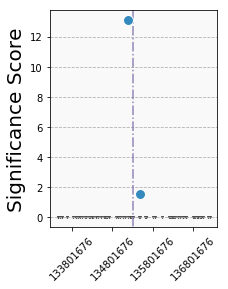

In [19]:
fig, ax = plt.subplots(figsize=(3,4))

ax.scatter(annot_df.loc[annot_df.idx.isin(local_gene_idx)].sort_values(by='idx').pos.values,
           plot_y_val[local_gene_idx] * -1,
           s=4,
           color='#4d4d4d',
           marker='v')

ax.axvline(int(left)+length_list[chr_order.index(enh_chrom)],
           color = '#7A68A6',
           ymin=ymin,
           ymax=ymax,
           linestyle='-.',
           alpha = 0.8)

ax.yaxis.grid(linestyle='--')
ax.set_facecolor('#F9F9F9')

hits_idx = np.intersect1d(np.squeeze(np.argwhere(plot_y_val < 0)), local_gene_idx)

ax.plot(annot_df.loc[annot_df.idx.isin(hits_idx)].pos.values,
        plot_y_val[hits_idx] * -1,
        '.',
        markersize=20,
        markerfacecolor='#348ABD',
        markeredgecolor='w')

ax.set_ylabel('Significance Score', fontsize=20)

locs = ax.xaxis.get_ticklocs()
locs = np.array([int(i) for i in locs])
ax.set_xticklabels(locs - length_list[chr_order.index(enh_chrom)], rotation = 45)

#fig.savefig('MYB-3_local_hits.pdf')

In [31]:
#show the local hits
for i in hits_idx:
  print(annot_df.loc[annot_df.idx == i].values[0])

[19997 'MYB' 'chr6' 1196379639 '+' 1 5]
[20001 'AHI1' 'chr6' 1196696100 '-' 1 5]


### Now we plot all the genes that are changed

Note that here we use SS > 2.8 for the up-reguated genes and SS > 1.9 for the down-regulated ones. 

In [32]:
up_cutoff = 2.8
down_cutoff = 1.9

In [33]:
def outlier_plot(ax, fc_list, plot_x_val, plot_y_val, outlier_idx, plot_idx, color):
    outlier_fc = np.array([])
    outlier_y_val = np.array([])
    outlier_x_val = np.array([])
        
    idx = np.intersect1d(plot_idx, outlier_idx)
    for j in idx:
        if fc_list[j] > 1:
            outlier_fc = np.append(outlier_fc, get_fc_range(fc_list[j]))
        else:
            outlier_fc = np.append(outlier_fc, get_fc_range(1/fc_list[j]))
            
        outlier_x_val = np.append(outlier_x_val, plot_x_val[j])
        outlier_y_val = np.append(outlier_y_val, plot_y_val[j])
        
    ax.scatter(outlier_x_val, outlier_y_val,
               color=color,
               s=outlier_fc,
               marker='o',
               edgecolor='w')

def get_fc_range(val):
    if (val >= 4):
        fc_range = 200
    elif (val >= 2):
        fc_range = 100
    else:
        fc_range = 50
    return fc_range

Text(3.18258e+09,32,'Up Genes')

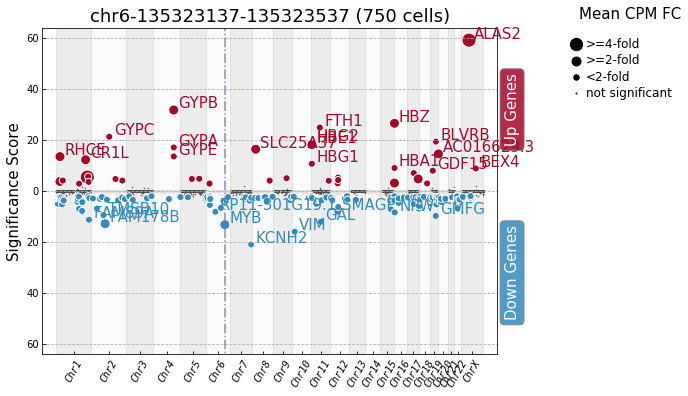

In [34]:
#initiate the figure
#plt.style.use('bmh')

fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(nrows=1, ncols=11)

#plot all genes
ax0 = fig.add_subplot(gs[:, 0:9])

ax0.scatter(plot_x_val[odd_idx],
           plot_y_val[odd_idx],
           s=1,
           color='#4d4d4d',
           marker='.')

ax0.scatter(plot_x_val[even_idx],
           plot_y_val[even_idx],
           s=1,
           color='#e0e0e0',
           marker='.')

ax0.set_title('%s (%d cells)'%(region, num_sgrna_cell),
             fontsize=18)

ax0.set_ylabel('Significance Score',
              fontsize = 15)

#configurate the axis
[ymin, ymax] = ax0.get_ylim()
max_yval = max([np.absolute(ymin), np.absolute(ymax)])
ax0.set_ylim([round(-max_yval-1),round(max_yval+1)])
#ax0.set_ylim([-30, 30])
ax0.set_xlim([-1e8, length_list[-1] + 1e8])
[ymin, ymax] = ax0.get_ylim()
ax0.tick_params(direction='in')
[xmin, xmax] = ax0.get_xlim()


#ax0.set_ylim([-30, 65])
#use absolute value for the y-axis
corrected_ylabels = np.array([])
labels = [np.absolute(int(i)) for i in ax0.get_yticks()]

ax0.set_yticklabels(labels)

#change the x-axis labels to chromosome names
xtick_pos = np.array([])
for i,e in enumerate(length_list):
    if i == 0:
        continue
    chrom_midpoint = (length_list[i-1] + e) / 2
    xtick_pos = np.append(xtick_pos, chrom_midpoint)
    
print_ChrNames = np.array([])
for i in chr_order:
    print_ChrNames = np.append(print_ChrNames, i[:1].upper() + i[1:])
    
ax0.set_xticklabels(print_ChrNames, 
                    rotation='60',
                    va='top',
                    ha='center',
                    style='oblique',
                    family='monospace')

for i,e in enumerate(length_list):
    if i == 0:
        continue
    if i % 2 == 0:
        ax0.fill_betweenx([ymin, ymax],
                          [length_list[i-1], length_list[i-1]],
                          [e, e],
                          color='#e0e0e0',
                          alpha=0.1)
    if i % 2 == 1:
        ax0.fill_betweenx([ymin, ymax],
                          [length_list[i-1], length_list[i-1]],
                          [e, e],
                          color='#4d4d4d',
                          alpha=0.1)
#setup the grid
#[s.set_visible(False) for s in ax0.spines.values()]
ax0.yaxis.grid(linestyle = '--')
ax0.set_xticks(xtick_pos)
        
#plot a vertical line at the position of enhancer
ax0.axvline(int(left)+length_list[chr_order.index(enh_chrom)],
           color = '#7A68A6',
           ymin=ymin,
           ymax=ymax,
           linestyle='-.',
           alpha = 0.8)

#plot the outliers
raw_outliers = []
counter = 0
for i,e in enumerate(plot_y_val):
    if (e < (-1* down_cutoff) or e > up_cutoff):
        raw_outliers.append(counter)
    counter += 1

outliers = np.intersect1d(raw_outliers, annot_df.idx)
if np.any(outliers):
    for j in outliers:
        if (plot_y_val[j] > 8) or (plot_y_val[j] < -8):
            gene_name = annot_df.loc[annot_df.idx == j].iloc[0].gene_names
            gene_chr = annot_df.loc[annot_df.idx == j].iloc[0].chromosome
            if plot_y_val[j] > 0:
                ax0.text(plot_x_val[j] + (xmax*0.01), plot_y_val[j] + (ymax*0.01),
                         '%s'%(gene_name),
                         color = '#A60628',
                         fontsize=15)
            else:
                ax0.text(plot_x_val[j] + (xmax*0.01), plot_y_val[j] + (ymax*0.01),
                         '%s'%(gene_name),
                         color='#348ABD',
                         fontsize=15)
          
    outlier_plot(ax0, fc, plot_x_val, plot_y_val, outliers, plot_up_idx, '#A60628')
    outlier_plot(ax0, fc, plot_x_val, plot_y_val, outliers, plot_down_idx, '#348ABD')

#manually plot a gene
'''ax0.scatter(plot_x_val[19997],
            plot_y_val[19997],
            s=20,
            color='k',
            edgecolor='w',
            marker='o')'''

#plot a legend for the circle size
ax1 = fig.add_subplot(gs[:,10])

y_len = ymax - ymin
y_val = []
for i in range(0,4):
    y_val.append(ymax - y_len * ((i + 1) * 0.05))

size = [150, 80, 30, 1]
legend_text = ['>=4-fold', '>=2-fold',
               '<2-fold', 'not significant']
for i,size in enumerate(size):
    ax1.scatter(0.5, y_val[i], 
                color = 'k',
                s=size,
                marker='o')
    ax1.text(0.7, y_val[i],
             '%s'%(legend_text[i]),
             ha='left',
             va='center',
             fontsize = 12)

ax1.axis('off')
ax1.set_ylim([ymin, ymax])
ax1.set_xlim([0.1,1])
ax1.set_title("Mean CPM FC",
              ha='left',
              va='bottom',
              fontsize = 15)

bbox_props=dict(boxstyle = 'round', fc='#348ABD', ec='0.5', alpha=0.85)
ax0.text(max(plot_x_val)*1.05, ymin*0.5, "Down Genes",
         ha='left',
         va='center',
         color='w',
         fontsize=15,
         rotation = 90,
         bbox=bbox_props)

bbox_props=dict(boxstyle = 'round', fc='#A60628', ec='0.5', alpha=0.85)
ax0.text(max(plot_x_val)*1.05, ymax*0.5, "Up Genes",
         ha='left',
         va='center',
         color='w',
         fontsize=15,
         rotation = 90,
         bbox=bbox_props)

#fig.savefig('%s.dual_manhattan.ver2.png'%(region), dpi=500)